# Data Science and Analysis with Python

### Data Source:

I am using data from my project for XXXX (Name Intentionally Hidden). This data is collected by a third party data gathering organization which specializes in Sleep Study Analytics.

#### Reason why I chose this data:
1. Having worked with this data set for 6 months now. I understand the functional concepts related to sleep studies.
2. This dataset was not readily available and was not analyzed before.
3. My Manager at XXX is happy to get additional insights from the data owned by her organization.

### Project Constraints

*  Most of the columns are categorical. We have therefore used Classification for all our insights.

* Being real world operational data, we have more than 50% of dependent variable columns are NULL which did not allow us to take into consideration the patients previous visits to the hospital and analyze on that.

* Legal Issue – We used high volume of sensitive PHI (Patient Health Information) from a health organization with advanced security auditing policies, we could not ask for additional data.


### Pre-Requisites

This .ipynb notebook contains images, therefore please either skip or set the path of the image file same as where the notebook is downloaded to.

### Column Definition

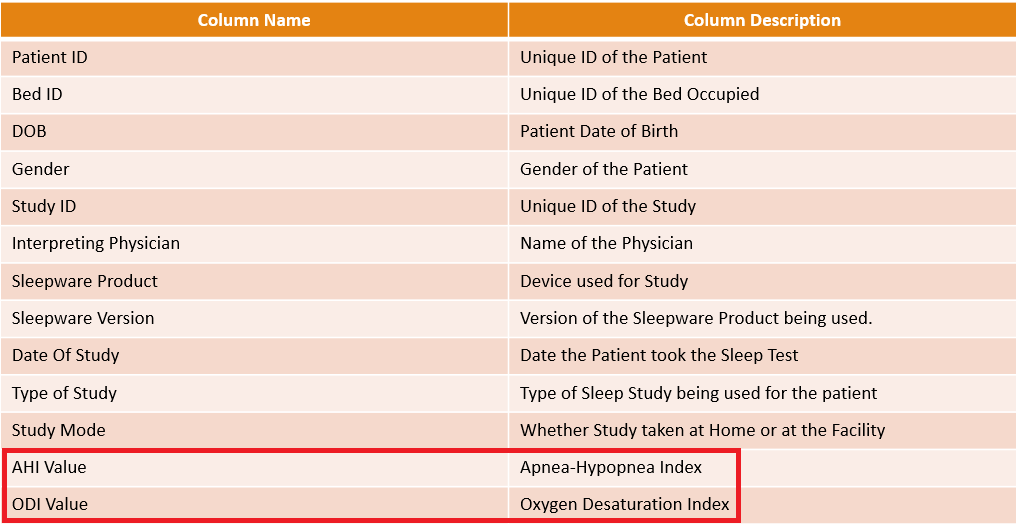

In [4]:
#Highlighting the most important values that revolve around our analysis
from IPython.display import Image
Image(filename='C:\\Users\\vaibh\\Downloads\\PythonProject-Vaibhav\\ColumnDefinition.png')

The highlighted columns - AHI Value and ODI Value are the only Jargons that are being used in our analysis.

<b> What Is AHI? </b>

AHI, or the apnea-hypopnea index, is a numerical measure that accounts for the number of pauses in your breathing per hour of sleep.

These breathing disturbances are typically associated with either a brief arousal or awakening from sleep or a 3 to 4 percent drop in the blood oxygen levels, called a desaturation. It is used to assess the severity of an individual’s sleep apnea. The AHI overlaps with the respiratory disturbance index (RDI), though the latter differs as it often includes other minor breathing difficulties. The AHI is part of the report from a standard sleep study for sleep apnea.

https://www.verywell.com/what-is-ahi-3015131

<b>What is ODI? </b>

The oxygen desaturation index (ODI) is the number of times per hour of sleep that the blood's oxygen level drop by a certain degree from baseline. The ODI is typically measured as part of standard sleep studies, such as a diagnostic polysomnogram, home sleep apnea testing, or with overnight oximetry.

https://www.verywell.com/oxygen-desaturation-index-3015362

Other insight specific jargons are explained under each insight separately.

### Row Definition

For all the three insights, we are using the same source data <b>"XXXX_Excel.xlsx"</b> and each row signifies a sleep study conducted at one or more XXXX facilities.

### Project Goal 

The data that we are dealing with is mostly categorical with only two columns that have continuous values. It's one reason we have chosen Classification as our Data Mining approach.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
from datetime import date, timedelta
from datetime import datetime
import pydotplus
%matplotlib inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [6]:
df = pd.read_excel('XXXX_Excel.xlsx')

### Generic Data Cleaning

Since we have Date of Birth, it makes sense to calculate present Age from it -  

In [7]:
today = datetime.now()
today = today.replace(second=0, microsecond=0)

In [8]:
df['AgeInDays'] = (today - df['dob'])
df['AgeInYears'] = df['AgeInDays'].apply(lambda x: int(x.days/365.2425))

In [9]:
df['location_id'] = df.location_id.astype(str)
df['bed_id'] = df.bed_id.astype(str)
df['zipcode'] = df.zipcode.astype(str)
df['study_id'] = df.study_id.astype(str)

In [10]:
df2 = pd.read_excel('StudyTypeCategorization.xlsx')
df2.drop('Details',axis=1,inplace=True)

In [11]:
df2.head()

,Study_Type,Study_Type_Category,Study_Type_Parent
0,Pulse OX,Oximetry,Diagnostic
1,NPSG,AST,Diagnostic
2,MSLT,AST,Diagnostic
3,MWT,AST,Diagnostic
4,PAT,HST,Diagnostic


Renaming value in Study_Type column so that it matches the original data file column value of WatchPAT:

In [12]:
df2['Study_Type'].loc[df2['Study_Type'] == 'PAT'] = 'WatchPAT'

Joining the two tables:

In [13]:
df = df.merge(df2,how='left',left_on='type_of_study',right_on='Study_Type')

In [15]:
df.shape

(59722, 23)

Binarizing all possible categorical values:

In [16]:
df.ix[df['Study_Type_Parent'] == 'Diagnostic','Study_Type_Parent'] = 1
df.ix[df['Study_Type_Parent'] == 'Titration','Study_Type_Parent'] = 0
df.ix[df['study_mode'] == 'HST','study_mode'] = 0
df.ix[df['study_mode'] == 'AST','study_mode'] = 1
df.ix[df['gender'] == 'Male','gender'] = 0
df.ix[df['gender'] == 'Female','gender'] = 1
df.ix[df['gender'] == 'Not Specified','gender'] = np.NAN #We want only binary data to work with for Gender

### Preliminary Raw-Data Analysis

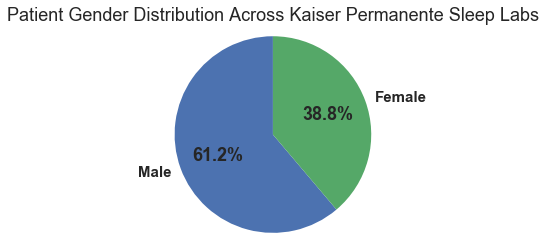

In [17]:
fig1, ax1 = plt.subplots()
sns.set(font_scale=1.5)
plt.title("Patient Gender Distribution Across XXXX Sleep Labs");
plt.pie(df["gender"].value_counts().tolist(), 
        labels=["Male", "Female"], 
        startangle=90,autopct='%.1f%%', 
        textprops={'weight': 'bold'});
ax1.axis('equal');

C:\Users\vaibh\AppData\Local\Enthought\Canopy\User\lib\site-packages\pandas\tools\plotting.py:983: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


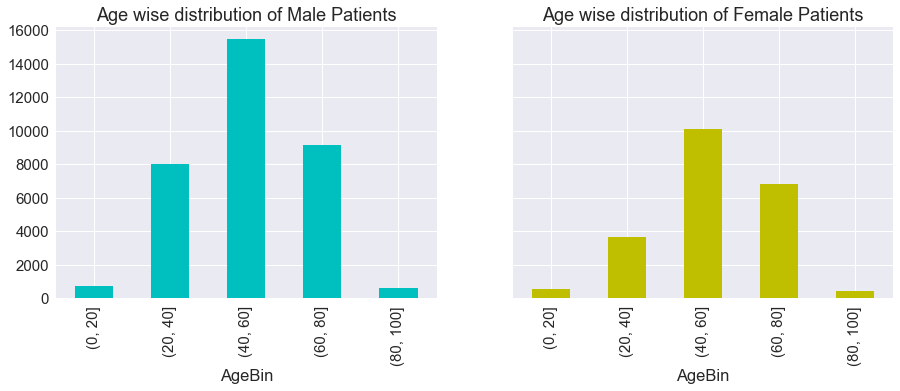

In [18]:
df['AgeBin'] = pd.cut(df.AgeInYears, bins= [0,20,40,60,80,100])
fig, ax = plt.subplots(1, 2,sharey=True);
df[df["gender"] == 0].groupby("AgeBin").size().plot(ax = ax[0], kind='bar', 
                                                    title='Age wise distribution of Male Patients', 
                                                    figsize=(15,5), colors=["c", "c"]);

df[df["gender"] == 1].groupby("AgeBin").size().plot(ax = ax[1],
                                                    kind='bar', 
                                                    title='Age wise distribution of Female Patients', 
                                                    figsize=(15,5),colors=["y", "y"]);

Let's also check for raw correlations within the data:

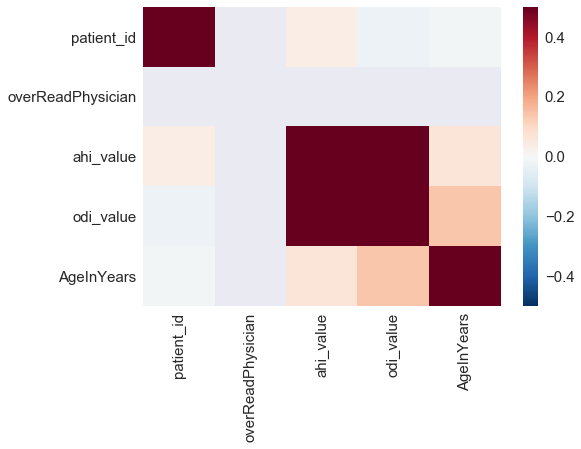

In [19]:
ga = df.corr()
sns.heatmap(ga,vmax=.5)

Below we are dropping categorical columns that are not going to be used for analysis.
We would have liked to keep date of study but all the subsets we chose to find patient's subsequent visits, most of the ODI/ AHI or both values were found as NULL. I decided to not consider the null valued rows.

In [20]:
df.drop(['location_id',
         'location_name',
         'patient_id', 
         'study_id', 
         'date_of_study',
         'zipcode', 
         'bed_id',
         'AgeInDays',
         'overReadPhysician',
         'sleepware_version', 
         'dob'], axis=1, inplace=True)

To make the analysis easier, we are only going to consider a subset of columns instead of all the available columns. Therefore, below we are going to copy the dataframe into two other dataframes that will be used for Insight 2 and Insight 3 respectively. You can see that the common transformtions have been completed earlier and the insight specific transformations will be done individually.

In [22]:
dfA = df.copy()
dfB = df.copy()
dfC = df.copy()

## Roadmap for Insight 1

The following part is added to increase the interestingness of the Business Problem.
Scenario - The Auditing team wants to analyze if there are any False Positives. <i> <u>More information on why we added the extra conditions are explained after the recommendation section in this notebook</u>. </i>

### Business Problem 1 - 
#### The hospital wants to analyze the patient health risks among the doctors who are highly rated. In which case, Is it possible that there are patients being treated by these physicians who have a risk of getting a heart related disorder in the future?


Let's also address the assumptions - 
 
1. Heart related disorders are mostly seen in Older males who are most likely to suffer from long term heart related problems.
2. Sleep tests are all about a person Since the patient undergoing the test only has to sleep, the tests whether taken at home or at the facility have no difference. 

We want to add Physicians and only select a few of them for our analysis, and although it's easy to just to .ix, we are going to create IDs for each physician assuming we have a Master Data for all the physicians available to us.

In [23]:
phy = df.interpretingPhysician.unique()
phy2 = pd.DataFrame(phy, dtype='str')
phy2.insert(0, 'New_ID', range(1, 1 + (len(phy2))))
phy2.columns
phy2.rename(columns={'New_ID': 'PhysicianID',0:'PhysicianName'},inplace=True)

In [24]:
dfA = dfA.merge(phy2,how='left',left_on='interpretingPhysician',right_on='PhysicianName')

In [25]:
dfA = pd.get_dummies(dfA, columns=['Study_Type_Category'])

Let's find who are the best Physicians by the number of studies undertaken:

In [27]:
dfA.groupby('PhysicianName')['type_of_study'].size().head()

PhysicianName
Adenuga, Olufemi      1011
Becker, Kendra        3659
Bercovitch, Robert    2889
Breid, Mona             85
Burton, Melvin          55
dtype: int64

Let's select only the best Physicians:

<b> Physician Name | Number of Studies  | </b>

 Hwang, Dennis  | 10219              |

 Yeh, Susie        | 8837               |

 Huang, Eric       | 6892               |

 Becker, Kendra    | 3659               |


In [28]:
phy2.head()

,PhysicianID,PhysicianName
0,1,"Yein, Thu"
1,2,"Hwang, Dennis"
2,3,"Huang, Eric"
3,4,"Monroe, Barry"
4,5,"Yeh, Susie"


In [29]:
dfA['PhysicianID'] = dfA.PhysicianID.astype(str)

Instead of filtering out Physicians by Name, we are assigning a randomly chosen value 99.0 and will later filter records based on it.

In [30]:
dfA.ix[dfA['PhysicianID'] == '2.0','PhysicianID'] = '99.0'
dfA.ix[dfA['PhysicianID'] == '5.0','PhysicianID'] = '99.0'
dfA.ix[dfA['PhysicianID'] == '3.0','PhysicianID'] = '99.0'
dfA.ix[dfA['PhysicianID'] == '14.0','PhysicianID'] = '99.0'

In [31]:
dfA = dfA[dfA.PhysicianID == '99.0']

In [32]:
dfA.drop(['Study_Type',
         'sleepware_product',
         'PhysicianID',
         'type_of_study',
         'interpretingPhysician'],axis=1,inplace=True)

In [33]:
dfA = pd.get_dummies(dfA, columns=['PhysicianName'])
dfA = pd.get_dummies(dfA, columns=['gender'])
dfA = pd.get_dummies(dfA, columns=['study_mode'])

In [34]:
len(dfA)

29607

In [35]:
dfA.rename(columns={'study_mode_1': 'TestAtFacility', 
                    'study_mode_0': 'TestAtHome',
                    'gender_0' : 'Male',
                    'gender_1' : 'Female' }, inplace=True)

In [36]:
dfA.dropna(axis=0, how='any',inplace=True)

In [37]:
dfA['AgeBinned'] = pd.cut(dfA.AgeInYears, bins= [0,5,20,40,60,90,1000])
dfA['Odi_Severity'] = pd.cut(dfA.odi_value, bins= [0,5,12,1000])

In [38]:
dfA = pd.get_dummies(dfA, columns=['AgeBinned','Odi_Severity'])

In [39]:
from sklearn.tree import DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(max_depth=2)

In [40]:
dfA.rename(columns={'Odi_Severity_(12, 1000]': 'HighHeartRisk'},inplace=True)

In [41]:
Y = dfA.HighHeartRisk
X = dfA.drop(['HighHeartRisk',
              'odi_value',
              'ahi_value',
              'Odi_Severity_(5, 12]',
              'Odi_Severity_(0, 5]',
              'AgeBin'],axis=1)

Training the Decision Tree Classifier:

In [42]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

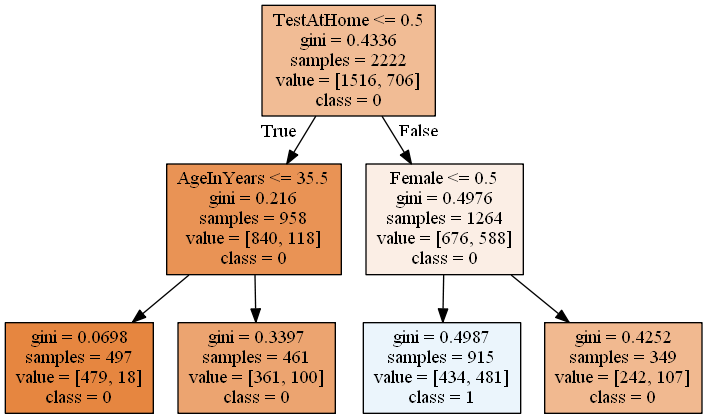

In [43]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Explanation - Here the dependent variable is "HighHeartRisk" and class 0 means that the person is not at high risk whereas class 1 means that patient is at high risk of heart related problems in the future.

## Insight 1 - The patients that prefer to take their tests at home (Leaf Node 3)instead of the hospital have the maximum risk of having Heart related problems. It is more likely the patient is male. But since the gini coefficient is approaching 0.50, there could be females too.

In [44]:
dfA_Proof = dfA.ix[dfA['TestAtFacility'] == 0]

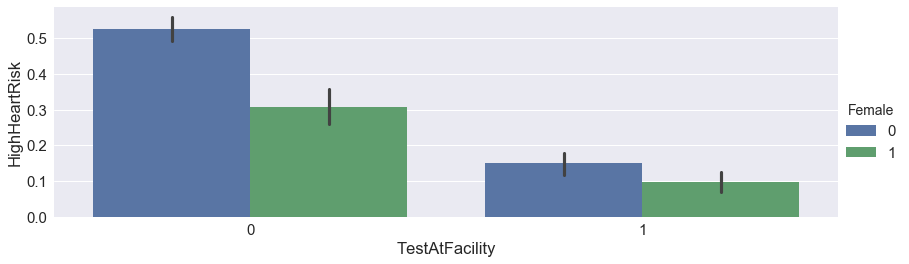

In [45]:
sns.factorplot(y='HighHeartRisk',x='TestAtFacility', hue='Female',data=dfA,kind='bar',aspect=3)

Key - 

* TestAtHome 0 => Test was undertaken the Facility

* TestAtHome 1 => Test was undertaken at home

* TestAtFacility 0 => Test was undertaken at home

* TestAtFacility 1 => Test was undertaken the Facility

* Female 0 => Patient is Male

* Female 1 => Patient is Female

## Roadmap for Insight 2

As seen from the Reference below and the screenshot attached; it is seen that Sleep Apnea is common among individuals who are mostly above the age of 40. Which makes sense as well as we are looking at those people in the age category who are having problems breathing and it could be due to multiple reasons. 

We want explore an insight that would not have been evident if it weren't for the Data Mining algorithms.

Reference - https://www.sleepapnea.org/learn/sleep-apnea/

Also snapshot attached below :

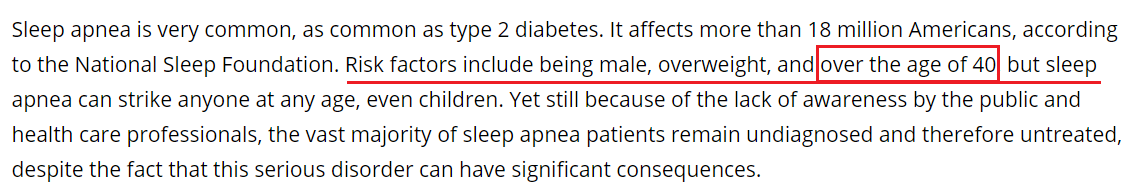

In [46]:
Image(filename='C:\\Users\\vaibh\\Downloads\\PythonProject-Group15-Vaibhav,Hamed\\SleepApneaCommonAbove40.png')

Let's also revisit the Heatmap to see if the data shows any correlation - 

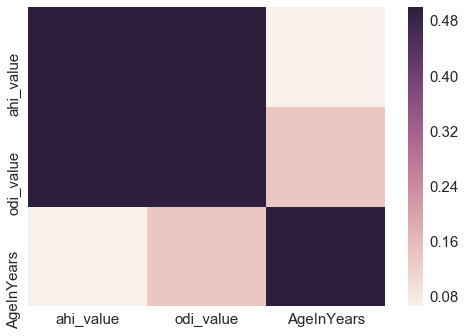

In [47]:
ga = df.corr()
sns.heatmap(ga,vmax=.5)

We (by now) know that High AHI corresponds to a definite case of Sleep Apnea. And looking at the correlation above, it also seems that ODI Value also decides if a patient has sleep apnea. Let's test if that holds true below:

### Business Problem 2 - 
#### The hospital wants to know to what extent ODI Value in a patient determines Sleep Apnea if they undertake the sleep test using the Sleepware G3 Product. So, a better way to address it will be to check what category of patients (using Sleepware G3) are NOT detected to have Sleep Apnea. In short, what is the difference between patients having Sleep Apnea and patients not having Sleep Apnea?

Removing columns that are not relevant to the insight 2.

In [48]:
dfB.drop(['interpretingPhysician',
          'Study_Type',
          'Study_Type_Category'
         ], axis=1, inplace = True)

Keeping Nulls out as they cannot be considered for the analysis.

In [49]:
dfB.dropna(axis=0, how='any',inplace=True)

In [50]:
dfB = pd.get_dummies(dfB, columns=['sleepware_product'])
dfB = pd.get_dummies(dfB, columns=['type_of_study'])

In [51]:
dfB['gender'] = dfB.gender.astype(int)
dfB['Study_Type_Parent'] = dfB.Study_Type_Parent.astype(int)
dfB['study_mode'] = dfB.study_mode.astype(int)

In [52]:
dfB['SleepApnea'] = pd.cut(df.ahi_value, bins= [0,5,15,30,2000])
dfB = pd.get_dummies(dfB, columns=['SleepApnea'])

In [53]:
dfB.rename(columns={'SleepApnea_(30, 2000]': 'SevereSleepApnea', 
                    'SleepApnea_(5, 15]':'LowSleepApnea',
                    'SleepApnea_(0, 5]':'NoSleepApnea',
                    'SleepApnea_(15, 30]' : 'ModerateSleepApnea', 'sleepware_product_Sleepware G3' : 'SleepwareProductG3'}, inplace=True)

In [54]:
from sklearn.tree import DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(max_depth=3)

In [55]:
dfB = dfB.ix[dfB['SleepwareProductG3'] == 1]

In [56]:
dfB.drop('SleepwareProductG3',axis=1,inplace=True)

In [57]:
Y = dfB.NoSleepApnea
X = dfB.drop(['LowSleepApnea',
              'ahi_value',
              'NoSleepApnea',
              'type_of_study_WatchPAT', 
              'type_of_study_BiPAP',
              'type_of_study_ASV',
              'type_of_study_NPSG',
              'type_of_study_Split Night CPAP',
              'type_of_study_CPAP',
              'type_of_study_Split Night BiPAP',
              'ModerateSleepApnea',
              'SevereSleepApnea', 
              'AgeBin'],axis=1)

Training the Decision Tree Classifier:

In [58]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

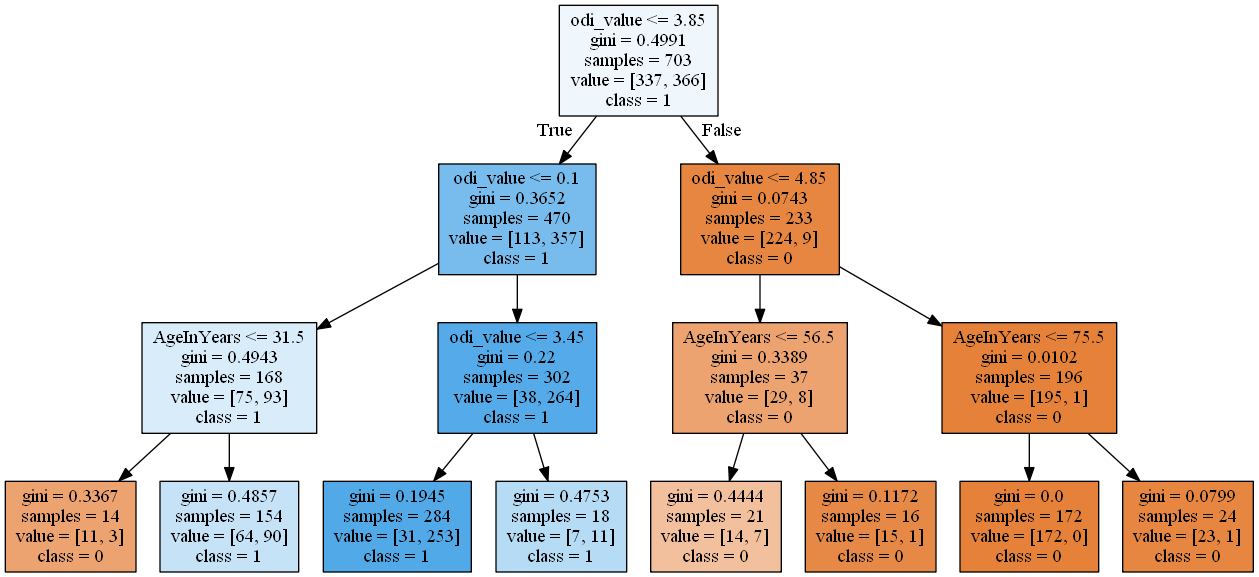

In [59]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())


Here the dependent variable is NoSleepApnea, so when Class from the decision tree is given out as 0, it would mean the person has some level of Sleep Apnea whereas when class is 1 it means that the person does not have Sleep Apnea. 

## Insight 2 - Patients over the age of 31 (Leaf Node 2)with extremely low ODI levels do NOT have Sleep Apnea. Thus, by what looks evident from the correlation should not be used to make a decision at all times.

#### Proving our Insight using Graphs:

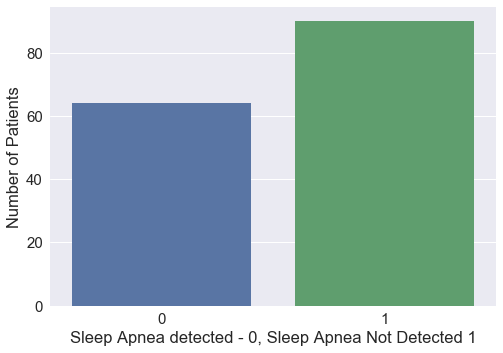

In [60]:
dfB2 = dfB.copy()
dfB2 = dfB2.ix[dfB2['odi_value'] < 0.1]
dfB2 = dfB2.ix[dfB2['AgeInYears'] > 31.5]
plot03 = sns.countplot(x='NoSleepApnea',data=dfB2)
plot03.set(ylabel="Number of Patients", xlabel="Sleep Apnea detected - 0, Sleep Apnea Not Detected 1");

## Roadmap to Insight 3

--- To add to the interestingness of the problem, we are adding the sleep product related scenario --- 

### Business Problem 3
####  The hospital wants to know if the newly purchased sleep product (ProFusion PSG) are consistent with legacy product results since they received a complaint that using the ProFusion PSG hampered medicare qualification for some middle aged  patients. In short, does the product affect the qualification of a patient to medicare and if yes, what characteristics are associated with it?

<i> Background - For Qualification of Medicare, the government needs the patient's AHI value to cross 5 per hour and in some cases between 5 and 14. For our dataset, and by what XXXX follows, we will consider an AHI value greater than 5 as grounds for qualification for Medicare. </i>
Reference - https://www.cms.gov/medicare-coverage-database/details/nca-decision-memo.aspx?NCAId=19&fromdb=true

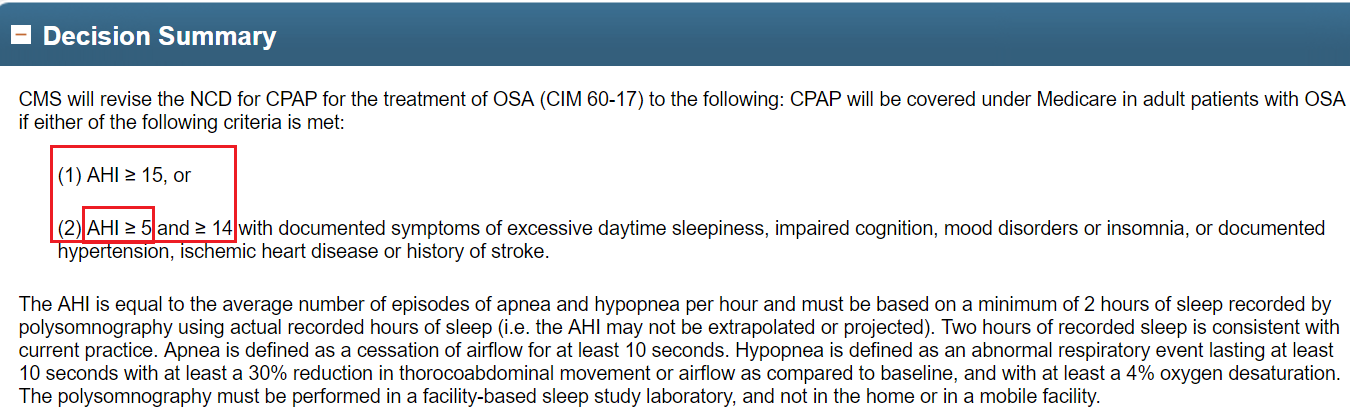

In [61]:
Image(filename='C:\\Users\\vaibh\\Desktop\\Spring 2017\\Python\\Project\\Presentation\\New Insight\\MedicareQualificationScreenshot.png')

Now, we need to take only those records for patient's that took the sleep test(s) using the "Sandman 10.1.2.1190". Since we are testing the newly purchased ProFusion PSG, we should be comparing it with a product that has been heavily tested in the past and is being used, monitored and regulated since a long time. Hence we are using "Sandman 10.1.2.1190" as a basis of comparison.

In [62]:
dfD = df.copy()
dfD = dfD.ix[dfD['sleepware_product'] == 'Sandman 10.1.2.1190']

Adding a column to the data frame that signifies whether the patient qualified for Medicare or not: 

In [63]:
dfD['QualifiesForMedicare'] = (dfD.ahi_value >= 5) * 1.0

In [64]:
dfD.drop(['Study_Type',
         'type_of_study',
         'interpretingPhysician', 
          'Study_Type_Parent',
          'odi_value',
          'Study_Type_Category'
         ],axis=1,inplace=True)

In [65]:
dfD = pd.get_dummies(dfD, columns=['AgeBin','gender','sleepware_product','study_mode'])

In [66]:
dfD.dropna(axis=0, how='any',inplace=True)

In [67]:
dfD['QualifiesForMedicare'] = dfD.QualifiesForMedicare.astype(int)

In [68]:
dfD.rename(columns={'gender_1': 'Female', 
                    'gender_0': 'Male'},inplace=True)

In [69]:
from sklearn.tree import DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(max_depth=2)

In [70]:
Y = dfD.QualifiesForMedicare
X = dfD.drop(['QualifiesForMedicare','ahi_value'],axis=1)

Training the Decision Tree Classifier:

In [71]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

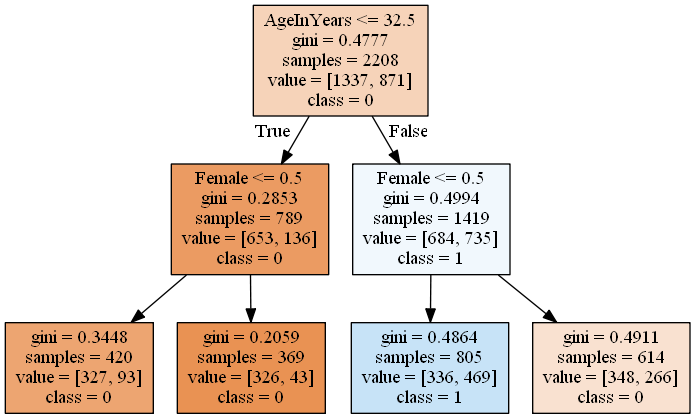

In [72]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

Let's consider the insight derived from this decision tree as the basis for the test on the actual product under monitoring. So the insight here is - 

### Insight (Basis for Actual Insight) - Male Patients over the average of 32 qualify for Medicare when tested through "Sandman 10.1.2.1190"

Now we, need to test the same scenario but this time with our test product which is - "ProFusion PSG". Since this is a new product, the number of tests conducted are also less in number.

In [73]:
dfE = df.copy()
dfE = dfE.ix[dfE['sleepware_product'] == 'ProFusion PSG']
dfE['QualifiesForMedicare'] = (dfE.ahi_value >= 5) * 1.0
dfE = pd.get_dummies(dfE, columns=['AgeBin','gender','sleepware_product','study_mode'])
dfE.drop('odi_value',axis=1,inplace=True)
dfE['QualifiesForMedicare'] = dfE.QualifiesForMedicare.astype(int)

In [74]:
dfE.drop(['Study_Type',
         'type_of_study',
         'interpretingPhysician', 
          'Study_Type_Parent',
          #'odi_value',
          'Study_Type_Category'
         ],axis=1,inplace=True)

dfE.rename(columns={'gender_1': 'Female', 
                    'gender_0': 'Male'},inplace=True)

In [75]:
from sklearn.tree import DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(max_depth=2)
Y = dfE.QualifiesForMedicare
X = dfE.drop(['QualifiesForMedicare','ahi_value'],axis=1)

In [76]:
dt.fit(X,Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

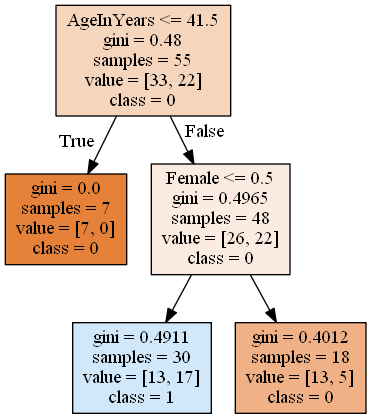

In [77]:
dt_feature_names = list(X.columns)
dt_target_names = np.array(Y.unique(),dtype=np.string_) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

## Insight 3 - Examining results show that patients using ProFusion PSG qualify more number of times for Medicare if they are Male and above the age of 41. This is contrasting from Sandman results which qualifies the patients with same gender as early as 32.

In [78]:
dfD2 = dfD.copy()
dfD2 = dfD2.ix[dfD2['AgeInYears'] > 32.5]
dfD2 = dfD2.ix[dfD2['Female'] == 0]

dfE2 = dfE.copy()
dfE2 = dfE2.ix[dfE2['AgeInYears'] > 41.5]
dfE2 = dfE2.ix[dfE2['Male'] == 1]

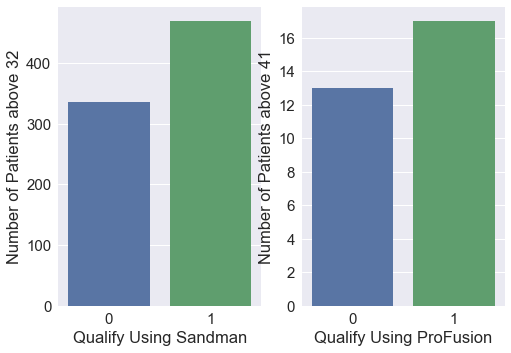

In [79]:
fig, ax =plt.subplots(1,2)
plot01 = sns.countplot(x='QualifiesForMedicare',data=dfD2, ax=ax[0])
plot02 = sns.countplot(x='QualifiesForMedicare',data=dfE2, ax=ax[1])
plot01.set(ylabel="Number of Patients above 32", xlabel="Qualify Using Sandman");
plot02.set(ylabel="Number of Patients above 41", xlabel="Qualify Using ProFusion");

Key - 
* Qualify Using Sandman 0 => Patient above the age of 32 and DOES NOT qualify for Medicare using the Sandman Sleep Device.

* Qualify Using Sandman 1 => Patient above the age of 32 and qualifies for Medicare using the Sandman Sleep Device.

* Qualify Using ProFusion 0 => Patient above the age of 41 and DOES NOT qualify for Medicare using the Sandman Sleep Device

* Qualify Using ProFusion 1 => Patient above the age of 41 and qualifies for Medicare using the Sandman Sleep Device

The two products achieve consistency only when they are used at different ages for patients.

## Recommendations to the Business:

<b>Insight 1</b> - The patients should be advised to take their sleep studies at the facility instead of home for early detection of Heart related problem.

<b>Insight 2</b> - ODI Value although correlated should not be considered by the physicians or insurance companies as measure of severity of Sleep Apnea. Recommendation is to proceed with case specific analysis to come up with conclusions. That requires more data at the disposal such as Weight, ElectroCardioGram data etc.

<b>Insight 3</b> - The newly purchased product ProFusion PSG should be analyzed with more tests and with advanced consultation from experts, the facility should decide if there is a need to re-calibrate the device.

# Thank you!!